In [16]:
import pandas as pd
import numpy as np
import numpy.typing as npt
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.transform import Rotation

In [2]:
directory_path="/Users/mm/Desktop/Myolab/imu_fitness_basic/armraise_v1.0/data"

In [3]:
rotation_matrix_labels = [
        "rotation_matrix_m11",
        "rotation_matrix_m12",
        "rotation_matrix_m13",
        "rotation_matrix_m21",
        "rotation_matrix_m22",
        "rotation_matrix_m23",
        "rotation_matrix_m31",
        "rotation_matrix_m32",
        "rotation_matrix_m33",
    ]

In [4]:
def rotation_matrices_to_eulers(data_path: str) -> npt.NDArray[np.float64]:
    imu_data = pd.read_csv(data_path)
    rotation_matrices=imu_data[rotation_matrix_labels].values.reshape(-1, 3, 3)
    eulers = Rotation.from_matrix(rotation_matrices).as_euler("xyz")
    imu_data.drop(rotation_matrix_labels, axis=1, inplace=True)
    imu_data["euler_X"] = eulers[:, 0]  
    imu_data["euler_Y"] = eulers[:, 1]  
    imu_data["euler_Z"] = eulers[:, 2]  
    return imu_data

Data Preparation

In [5]:
armraise_df=[]
for subdir, dirs, files in os.walk(directory_path):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(subdir, file)
            df=rotation_matrices_to_eulers(file_path)
            if 'Unnamed: 0' in df.columns:
                df.drop('Unnamed: 0', axis=1, inplace=True)
                
            armraise_df.append(df)

In [6]:
armraise_df = pd.concat(armraise_df, ignore_index=True)

In [7]:
armraise_df.head()

,rep_count_from_intermediate,rep_count_from_start,ref_xy_rotation,time,euler_X,euler_Y,euler_Z
0,0.464286,0.000000,5.247949,0.00,-0.099967,-1.120315,-2.915097
1,0.481861,0.017575,5.247949,0.05,-0.103568,-1.109266,-2.913372
2,0.499241,0.034955,5.247949,0.10,-0.110496,-1.085316,-2.904828
3,0.516428,0.052142,5.247949,0.15,-0.112742,-1.060064,-2.899468
4,0.533423,0.069137,5.247949,0.20,-0.112582,-1.031245,-2.894379


In [8]:
armraise_df.shape

(95636, 7)

In [9]:
armraise_df.isnull().sum()

rep_count_from_intermediate    0
rep_count_from_start           0
ref_xy_rotation                0
time                           0
euler_X                        0
euler_Y                        0
euler_Z                        0
dtype: int64

In [10]:
armraise_df.to_csv('armraise_euler.csv', index=False)

Column definitions:

rep_count_from_intermediate: is indexed to the point of maximum flexion.

rep_count_from_start: is indexed to the beginning of the recording.

ref_xy_rotation: Rotation in the XY plane of the reference orientation is measured in radians (simulating the xArbitraryZVertical reference in the Apple CoreMotion SDK).

time: elapsed time from the start of the recording

euler_X: euler angle => rotation around X-axis => side-to-side movements

euler_Y: euler angle => rotation around Y-axis => forward and backward movements

euler_Z: euler angle => rotation around Z-axis => turning or rotational movements


In [11]:
armraise_df[['euler_X', 'euler_Y', 'euler_Z']].describe()

,euler_X,euler_Y,euler_Z
count,95636.000000,95636.000000,95636.000000
mean,0.019026,0.033538,0.074263
std,0.556123,0.509340,1.704864
min,-1.489829,-1.380036,-3.141479
25%,-0.381934,-0.325009,-1.256380
50%,-0.004334,0.023583,0.034474
75%,0.419016,0.393266,1.662800
max,1.531014,1.503450,3.141347


Euler angle ranges are from -pi to pi

euler_X range: -1.489829 to 1.531014
euler_Y range: -1.380036 to 1.503450
euler_Z range: -3.141479 to 3.141347 suggests full round rotation

Mean's for all the euler angles seem to be close to 0 implying no significant bias

euler_Z has the highest standard deviation hence implies high variance might be due to high number of twists and turns. euler_X and euler_Y comparitively don't have much variance.


In [14]:
mean_x = armraise_df.euler_X.mean()
std_x = armraise_df.euler_X.std()

mean_y = armraise_df['euler_Y'].mean()
std_y = armraise_df['euler_Y'].std()

mean_z = armraise_df['euler_Z'].mean()
std_z = armraise_df['euler_Z'].std()

armraise_df['z_score_x'] = (armraise_df['euler_X'] - mean_x) / std_x
armraise_df['z_score_y'] = (armraise_df['euler_Y'] - mean_y) / std_y
armraise_df['z_score_z'] = (armraise_df['euler_Z'] - mean_z) / std_z

x_outliers_z = armraise_df[np.abs(armraise_df['z_score_x'])>3]
y_outliers_z = armraise_df[np.abs(armraise_df['z_score_y']) > 3]
z_outliers_z = armraise_df[np.abs(armraise_df['z_score_z'])>3]
print("X outliers")
print(x_outliers_z)
print("Y outliers")
print(y_outliers_z)
print("Z outliers")
print(z_outliers_z)

X outliers
Empty DataFrame
Columns: [rep_count_from_intermediate, rep_count_from_start, ref_xy_rotation, time, euler_X, euler_Y, euler_Z, z_score_x, z_score_y, z_score_z]
Index: []
Y outliers
Empty DataFrame
Columns: [rep_count_from_intermediate, rep_count_from_start, ref_xy_rotation, time, euler_X, euler_Y, euler_Z, z_score_x, z_score_y, z_score_z]
Index: []
Z outliers
Empty DataFrame
Columns: [rep_count_from_intermediate, rep_count_from_start, ref_xy_rotation, time, euler_X, euler_Y, euler_Z, z_score_x, z_score_y, z_score_z]
Index: []


No outliers across all the euler angles

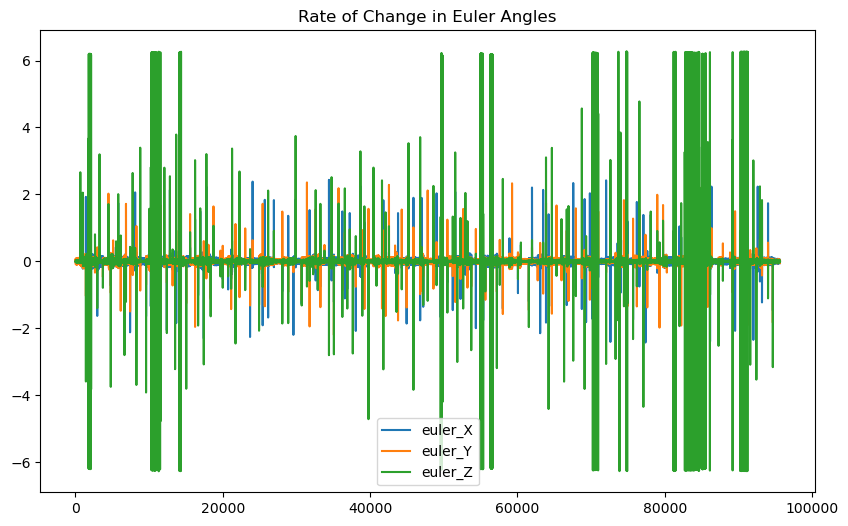

In [15]:
# checking consistency in euler angles
armraise_df[['euler_X', 'euler_Y', 'euler_Z']].diff().plot(figsize=(10, 6))
plt.title('Rate of Change in Euler Angles')
plt.show()

The rate of change of Euler_Z <=> Variance across Euler_Z

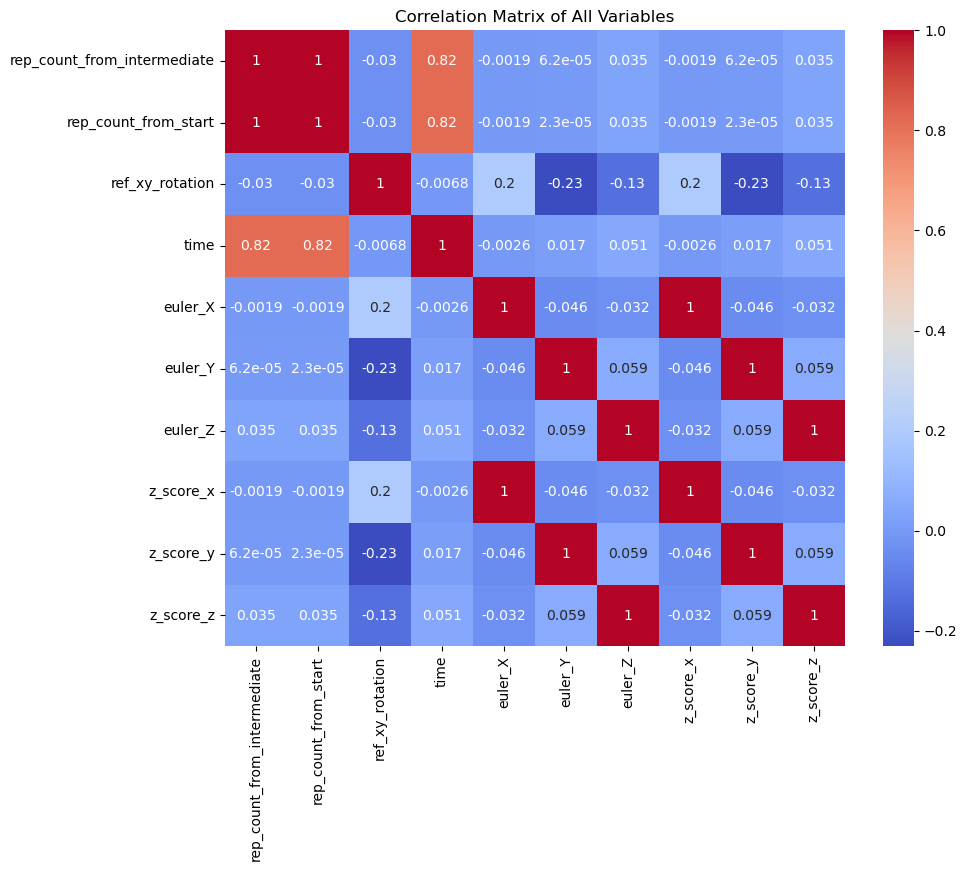

In [17]:
correlation_matrix = armraise_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of All Variables')
plt.show()

High correlation between (rep_count_from_intermediate and time) and (rep_count_from_start and time) shows progression of exercise.

Low correlation between the euler angles suggest that movements across X,Y and Z-axis are independent from each other.

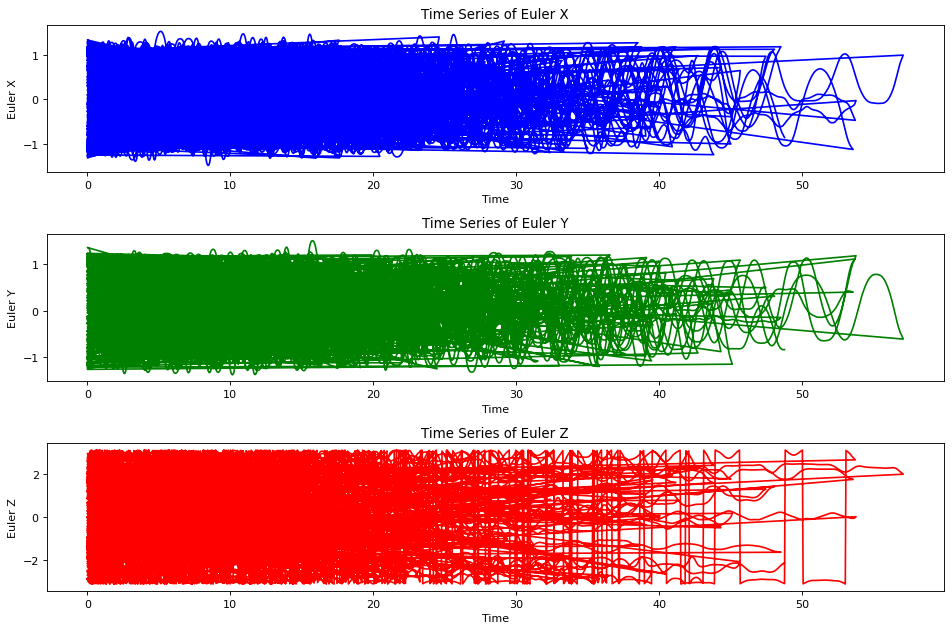

In [18]:
plt.figure(figsize=(12, 8), dpi=80)

# Plotting Euler X
plt.subplot(3, 1, 1)  
plt.plot(armraise_df['time'], armraise_df['euler_X'], label='Euler X', color='blue')
plt.title('Time Series of Euler X')
plt.xlabel('Time')
plt.ylabel('Euler X')

# Plotting Euler Y
plt.subplot(3, 1, 2)  
plt.plot(armraise_df['time'], armraise_df['euler_Y'], label='Euler Y', color='green')
plt.title('Time Series of Euler Y')
plt.xlabel('Time')
plt.ylabel('Euler Y')

# Plotting Euler Z
plt.subplot(3, 1, 3)  
plt.plot(armraise_df['time'], armraise_df['euler_Z'], label='Euler Z', color='red')
plt.title('Time Series of Euler Z')
plt.xlabel('Time')
plt.ylabel('Euler Z')

plt.tight_layout()
plt.show()

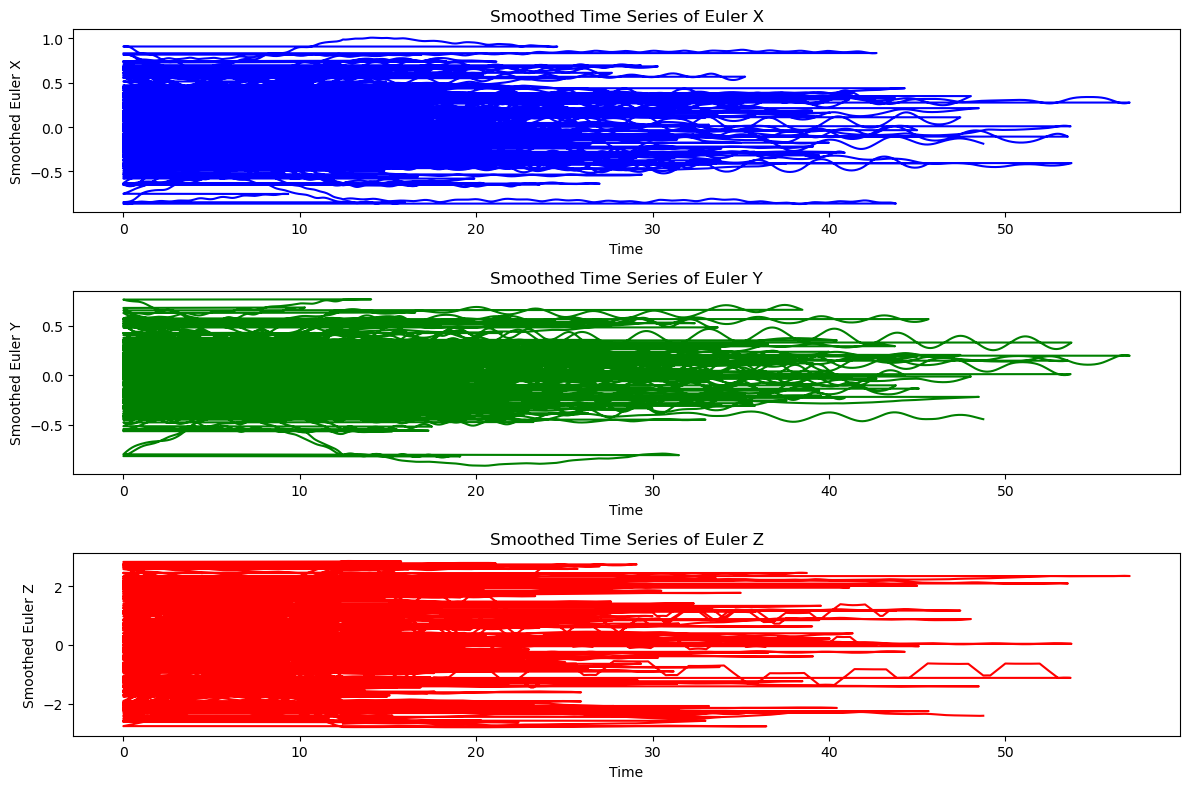

In [28]:
window_size = 250  
armraise_df['euler_X_sma'] = armraise_df['euler_X'].rolling(window=window_size).mean()
armraise_df['euler_Y_sma'] = armraise_df['euler_Y'].rolling(window=window_size).mean()
armraise_df['euler_Z_sma'] = armraise_df['euler_Z'].rolling(window=window_size).mean()

# Plotting the smoothed data
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(armraise_df['time'], armraise_df['euler_X_sma'], label='Smoothed Euler X', color='blue')
plt.title('Smoothed Time Series of Euler X')
plt.xlabel('Time')
plt.ylabel('Smoothed Euler X')

plt.subplot(3, 1, 2)
plt.plot(armraise_df['time'], armraise_df['euler_Y_sma'], label='Smoothed Euler Y', color='green')
plt.title('Smoothed Time Series of Euler Y')
plt.xlabel('Time')
plt.ylabel('Smoothed Euler Y')

plt.subplot(3, 1, 3)
plt.plot(armraise_df['time'], armraise_df['euler_Z_sma'], label='Smoothed Euler Z', color='red')
plt.title('Smoothed Time Series of Euler Z')
plt.xlabel('Time')
plt.ylabel('Smoothed Euler Z')

plt.tight_layout()
plt.show()

Timeseries plots analysis:

Euler X maintains a relatively stable range with minimal fluctuations.
Euler Y demonstrates more variability compared to Euler X. 
Euler Z shows regular oscillatory fluctuations which suggest rise and fall repetitively that indicate that the exercise is performed in a steady, rhythmic manner. Hence, Euler Z might be considered as the primary axis of rotation for this exercise.